In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

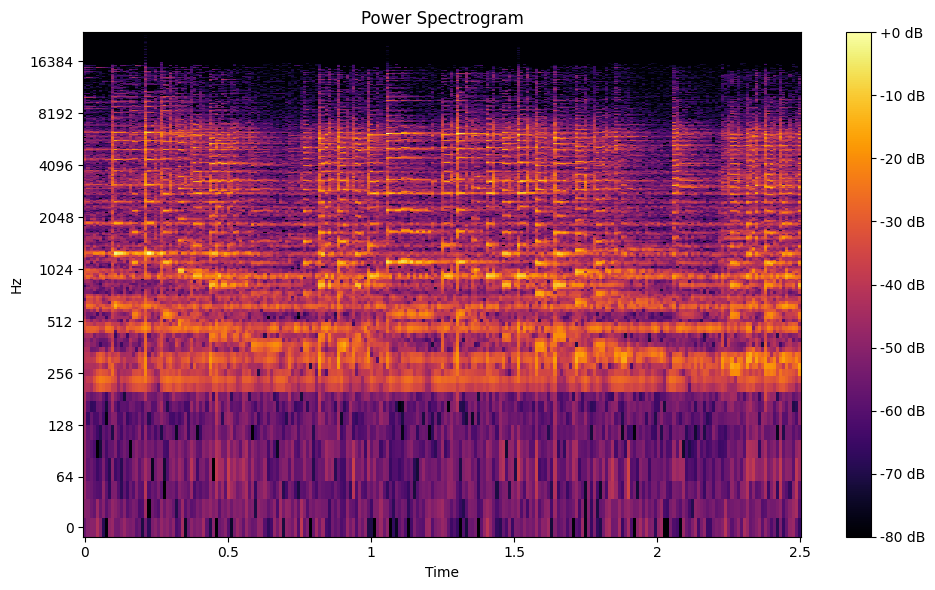

In [3]:



# Load the WAV file
filename = "audio_files/sitar_noisy3.wav"  # Replace with your file path
y, sr = librosa.load(filename, sr=None)

# Compute the Short-Time Fourier Transform (STFT)
D = librosa.stft(y,hop_length=4096//2)

# Compute the power spectrogram (magnitude squared)
Y = np.abs(D)**2

# Convert power spectrogram to decibels for better visualization
S_dB = librosa.power_to_db(Y, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='log', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram')
plt.tight_layout()
plt.show()


## HPSS

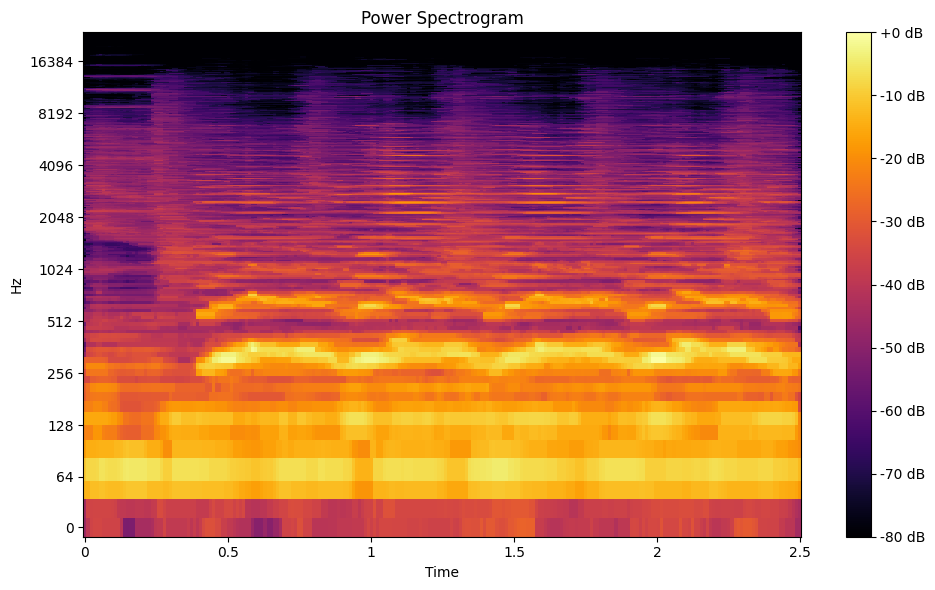

In [ ]:
def horizontal_median_filter(B, size):
    return np.apply_along_axis(lambda m: signal.medfilt(m, size), axis=1, arr=B)

def vertical_median_filter(B, size):
    return np.apply_along_axis(lambda m: signal.medfilt(m, size), axis=0, arr=B)
    
def apply_median_filter(Y, h_size, p_size):
    harmonic_spectrogram = horizontal_median_filter(Y, h_size)
    percusive_spectogram = vertical_median_filter(Y, p_size)
    
    return harmonic_spectrogram, percusive_spectogram

Y_h, Y_p = apply_median_filter(Y, h_size=11, p_size=11)

# Convert power spectrogram to decibels for better visualization
S_dB = librosa.power_to_db(Y_h, ref=np.max)
# Display the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='log', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram')
plt.tight_layout()
plt.show()

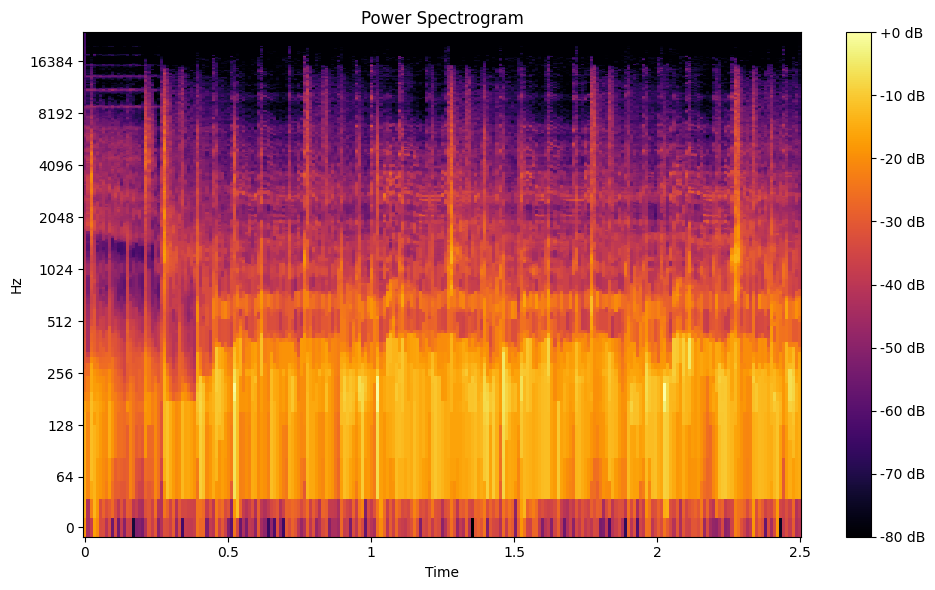

In [ ]:
# Convert power spectrogram to decibels for better visualization
S_dB = librosa.power_to_db(Y_p, ref=np.max)
# Display the spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='log', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram')
plt.tight_layout()
plt.show()

In [ ]:
# your code here...
def convert_to_indices(lh_sec, lp_Hz, Fs, N, H):
    L_h = int(np.ceil(Fs * lh_sec / H))
    L_d = int(np.ceil(N * lp_Hz / Fs))
    return L_h if not L_h % 2 == 0 else L_h + 1, L_d if not L_d % 2 == 0 else L_d + 1

def apply_median_filter(Y, h_size, p_size):
    harmonic_spectrogram = horizontal_median_filter(Y, h_size)
    percusive_spectogram = vertical_median_filter(Y, p_size)
    
    return harmonic_spectrogram, percusive_spectogram


def binary_mask(Y_h, Y_p):
    mask_h = Y_h >= Y_p
    return mask_h, ~mask_h

    
def HPSS(x, N, H, w, Fs, lh_sec, lp_Hz):
    # x:      Input signal
    # N:      Frame length
    # H:      Hopsize
    # w:      Window function of length N
    # Fs:     Sampling rate of x
    # lh_sec: Horizontal median filter length given in seconds
    # lp_Hz:  Percussive median filter length given in Hertz

    # stft
    X = librosa.stft(x, hop_length=H, n_fft=N, window=w)

    # power spectrogram
    Y = np.abs(X) ** 2

    # median filtering
    L_h, L_p = convert_to_indices(lh_sec, lp_Hz, Fs, N, H)
    print(L_h, L_p)
    Y_h, Y_p = apply_median_filter(Y, *convert_to_indices(lh_sec, lp_Hz, Fs, N, H))

    # masking
    M_h, M_p = binary_mask(Y_h, Y_p)
    X_h, X_p = X * M_h, X * M_p
    
    # istft
    x_h, x_p = librosa.istft(X_h), librosa.istft(X_p)
    
    return x_h, x_p

In [ ]:
x, Fs = sf.read(file)
x_h, x_p = HPSS(x, 1024, 512, "hann", Fs, 0.2, 500)

print('Orignal')
display(Audio(x, rate=Fs))
print('Harmonic Component')
display(Audio(x_h, rate=Fs))
print('Percussive Component')
display(Audio(x_p, rate=Fs))